## Практическое задание к уроку № 3 по теме "Логистическая регрессия. Log Loss".

#### Задание 1.  
*Измените функцию `calc_logloss`, рассмотренную на уроке, так, чтобы нули по возможности не попадали  
в `np.log` (как вариант - использовать `np.clip` или `np.where`).*  

In [1]:
import numpy as np

In [2]:
def calc_logloss(y, p):
    p = np.clip(p, 1e-5, 0.9999)
    return np.mean(- y * np.log(p) - (1.0 - y) * np.log(1.0 - p))

#### Задание 2.  
*На данных из урока изучите влияние гиперпараметров на ошибку алгоритма.  
Подберите аргументы функции `eval_LR_model` для логистической регрессии таким образом,  
чтобы log loss не превышал значение `0.3` `(0.1).` Как изменились веса?*

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [4]:
def eval_LR_model(X, y, iterations, eta=1e-4, verbose=False):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    errors = []
    w_01 = None
    w_03 = None
    for i in range(1, iterations + 1):
        z = np.dot(X, w) # log(p/(1-p))
        pred = sigmoid(z) # p [0, 1]
        err = calc_logloss(y, pred)
        if np.allclose(err, 0.3, atol=1e-3):
            w_03 = w.copy()
        if np.allclose(err, 0.1, atol=1e-3):
            w_01 = w.copy()
        errors.append(err)
        w -= eta * (1/n * np.dot((pred - y), X))
        if verbose and (i % (iterations / 10)) == 0:
            print(i, w, err)
    return errors, w, w_03, w_01

Даны данные:

In [5]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],  # стаж репетитора
              [500, 700, 750, 600, 1450,        # средняя стоимость занятия
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]],  # квалификация репетитора
              dtype = np.float64).T 

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1]) # поступил или нет ученик на специальность Математика

Стандартизируем столбец со стоимостью занятий:

In [6]:
X[:, 2] = (X[:, 2] - np.mean(X[:, 2])) / np.std(X[:, 2])

In [7]:
# eta = np.logspace(-3, 0, num=4)
eta = (0.1, 0.5, 1, 1.5)
weights = {}
logloss = {}
tw_01 = {}
tw_03 = {}
iterations = 10000
for i in eta:
    e, w, w_03, w_01 = eval_LR_model(X, y, iterations=iterations, eta=i)
    weights[i] = w
    logloss[i] = e
    tw_01[i] = w_01 if np.all(w_01) else None
    tw_03[i] = w_03 if np.all(w_03) else None

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})

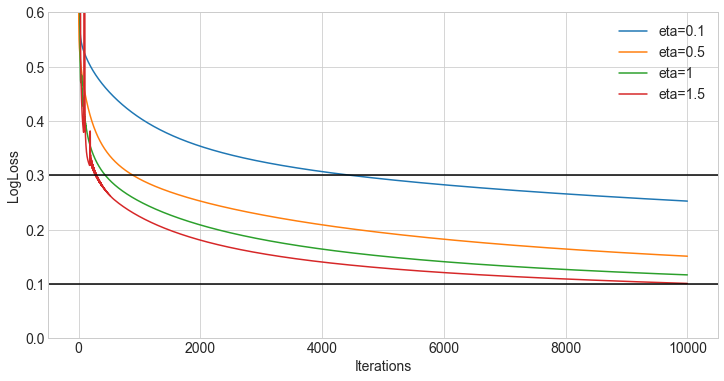

In [9]:
plt.figure(figsize=(12,6))

for i in eta:
    plt.plot(range(iterations), logloss[i], label=f'eta={i}')

plt.ylim(0, 0.6)
plt.axhline(y=0.3, color='black')
plt.axhline(y=0.1, color='black')
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.legend()
plt.show()

Был протестирован алгоритм логистической регрессии при различных значениях шага (коэффициента `eta`) и с ограничением количества итераций до 10000. Величину Logloss=0,3 преодолели все модели. При шаге 0,1 для этого понадобилось около 4500 итераций, при шаге 0,5 - 1000 итераций, при шагах 1,0 и 1,5 - около 500 и менее 500 итераций соответственно. Значения весов при такой ошибке составили:

In [10]:
tw_03[0.1]

array([-7.45111188, -1.17341519, -1.1526711 ,  6.49844572])

In [11]:
tw_03[0.5]

array([-7.44843255, -1.1732417 , -1.15178002,  6.49640895])

In [12]:
tw_03[1.0]

array([-7.44696304, -1.17314438, -1.15129452,  6.49528797])

In [13]:
tw_03[1.5]

array([-8.04347702, -1.36696433, -1.3152012 ,  6.97965308])

На уроке мы получили значения весов [-2.77136565 -0.99588853  0.56641089  3.26813012] при ошибке 0,4. Видно, что некоторые веса существенно изменились для получения ошибки 0,3.

Величину Logloss=0,1 преодолела только одна модель, с шагом 1,5. Для этого ей понадобилось около 10000 итераций. Значение весов при такой ошибке составило:

In [14]:
tw_01[1.5]

array([-42.67366964,  -4.17915656, -11.59318886,  34.83142129])

Хоть эта модель и показала низкое значение ошибки, значения весов сильно отличаются от весов при ошибке 0.3, и по модулю они велики. Это может свидетельствовать о переобучении модели, и высока вероятность, что на незнакомых данных модель будет плохо предсказывать.

#### Задание 3.  
*Создайте функцию `calc_pred_proba`, возвращающую предсказанную вероятность класса "1".  
На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией `eval_LR_model`.*

In [15]:
def calc_pred_proba(X, w):
    return sigmoid(X @ w)

In [16]:
calc_pred_proba(X, tw_03[1.0])

array([0.2695271 , 0.18665631, 0.97660462, 0.22540282, 0.71020575,
       0.36907871, 0.99280157, 0.10657547, 0.29352856, 0.95843194])

#### Задание 4.  
*Создайте функцию `calc_pred`, возвращающую предсказанные классы (0 или 1).  
На вход функции подаются значения признаков Х и веса, которые уже посчитаны функцией `eval_LR_model`, а также порог вероятности.*

In [17]:
def calc_pred(X, w, threshold):
    p = calc_pred_proba(X, w)
    return np.where(p >= threshold, 1, 0)

In [18]:
calc_pred(X, tw_03[1.0], 0.6)

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

#### Задание 5*.  
*Напишите функции для расчета accuracy, матрицы ошибок, precision и recall, а также F1-score.*

Создадим класс с функциями для расчёта метрик:

In [19]:
class MyMetrics:
    
    def __init__(self, y_true, y_pred):
        
        self.y_true = y_true
        self.y_pred = y_pred
        
        # True Negative
        self.TN = ((self.y_true == 0) & (self.y_pred == 0)).sum()
        
        # False Positive
        self.FP = ((self.y_true == 0) & (self.y_pred == 1)).sum()
        
        # False Negative
        self.FN = ((self.y_true == 1) & (self.y_pred == 0)).sum()
        
        # True Positive
        self.TP = ((self.y_true == 1) & (self.y_pred == 1)).sum()
    
    def accuracy(self):
        return (self.TP + self.TN) / (self.TP + self.FP + self.TN + self.FN)
    
    def precision(self):
        return self.TP / (self.TP + self.FP)
    
    def recall(self):
        return self.TP / (self.TP + self.FN)
    
    def confusion_matrix(self):
        return np.array([[self.TP, self.FP], [self.FN, self.TN]])
    
    def f1_score(self):
        return 2 * self.precision() * self.recall() / (self.precision() + self.recall())

Протестируем работу:

In [20]:
# Предсказанные значения:
y_pred = calc_pred(X, tw_03[0.1], 0.5)
y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [21]:
# Истинные значения:
y

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [22]:
metrics = MyMetrics(y, y_pred)

In [23]:
metrics.accuracy()

0.9

In [24]:
metrics.precision()

1.0

In [25]:
metrics.recall()

0.8

In [26]:
metrics.f1_score()

0.888888888888889

In [27]:
metrics.confusion_matrix()

array([[4, 0],
       [1, 5]])